# Step 1: Installing flowdec. If using Colab run from step 1. Else execute from step 3.


In [3]:
!pip install flowdec

# Step 2: Uploading image

In [4]:
from google.colab import files

uploaded = files.upload()#creating file input stream

for fn in uploaded.keys():#getting the input bytes
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))#get name and length of file


Saving 3mem_3m0_1-1 ROI 1_crop_crop_crop_Cy3.tif to 3mem_3m0_1-1 ROI 1_crop_crop_crop_Cy3.tif
User uploaded file "3mem_3m0_1-1 ROI 1_crop_crop_crop_Cy3.tif" with length 18726912 bytes


# Step 3 : Import image and check for shape, dimension and datatype

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import dask
import dask.array as da
from skimage import (
     io
)

data = io.imread('3mem_3m0_1-1 ROI 1_crop_crop_crop_Cy3.tif')#import file path
z,y,x=data.shape#getting image shape
print(z,y,x)
print(data.ndim)
print(data.dtype)

94 314 315
3
uint16


# Step 4: Calculating chunk shape

In [132]:
def calc(a):#calculating the chunk size by dividing by 2
  if(a%2==0):
    return int(a/2)#for even length return length by 2
  else:
    return int(a/2)+1 #for odd length round up 
Zn=z#new z value same as original
Yn=calc(y)#new y value calulated as y by 2
Xn=calc(x)#new x value calculated as x by 2
print(Zn,Yn,Xn)

94 157 158


# Step 5: Performing Decon

In [133]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from flowdec.nb import utils as nbutils 
from flowdec import psf as fd_psf
from flowdec import data as fd_data
from scipy import ndimage
import dask
import dask.array as da
import tensorflow as tf
from flowdec.restoration import RichardsonLucyDeconvolver



import operator
def cropND(img, bounding):#cropping image
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))#dividing lengths by 2
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))#make slices of given shape(bounding)
    return img[slices]


# chunked dask array
arr = da.from_array(data, chunks=(Zn,Yn,Xn))#Xn,Yn,Zn are new shapes where X and Y are divided by 2 and Z axis is same
# kernel cropped to chunk size

def decon2(chunk):#deconvolution function
  if(chunk.shape[0]!=0):#to eliminate initializing empty chunk
    
    x1,y1,z1=chunk.shape
    psf = fd_psf.GibsonLanni(
    pz=0.4,#z value
    na=1.4,#numerical aperture          
    m=40,  #magnification
    ns=1.33,  #specimen RI         
    ni0=1.5,  #immersion RI 
    tg0 =200,
    ti0=100,
    tg=200,     
    res_lateral=5.5, # X/Y resolution
    res_axial=0.16,     # Axial resolution
    wavelength=.700,  # Emission wavelength 
    num_basis=300,
    num_samples=1000,
    size_x=x, 
    size_y=y, 
    size_z=z).generate()
    #print(psf)
    
    psf = cropND(psf, (x1-12,y1-12,z1-12))#cropping kernel with chunk shape, padding 6,6,6 is used hence for each axis 6 is padded on each side thus -12 is used to get non-padded value. kernel cannot have overlap, only chunk has
    algo = RichardsonLucyDeconvolver(data.ndim, pad_mode="2357", pad_min=(6,6,6))#pad_mode->default padding type, pad_min->overlap for each axis, that can be changed
    
    
    print("Applying deconvolution...")
    res = algo.initialize().run(fd_data.Acquisition(data=chunk, kernel=psf), 1)#running the LR algo on chunk with cropped kernel
    

    return res.data#returning output

result2 = arr.map_overlap(decon2,depth=(6,6,6), boundary='reflect', dtype='float64').compute(num_workers=1)#depth: overlap (can be chnaged), boundary->default, dtype->data type of image, num_workers-> number of CPU processors to be used.


Applying deconvolution...
Applying deconvolution...
Applying deconvolution...
Applying deconvolution...


In [134]:
result=result2.astype('uint16')#changing back to original dtype

# Step 6: Print decon image

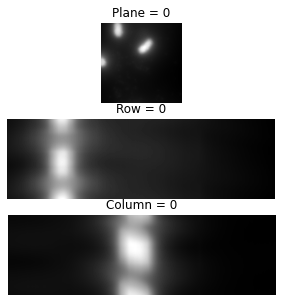

In [135]:
def show_plane(ax, plane, cmap="gray", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.axis("off")

    if title:
        ax.set_title(title)
(n_plane, n_row, n_col) = result.shape
_, (a, b, c) = plt.subplots(nrows=3, figsize=(15, 5))
show_plane(a, result[0], title=f'Plane = {0}')
show_plane(b, result[:, 0, :], title=f'Row = {0}')
show_plane(c, result[:, :, 0], title=f'Column = {0}')

# Step 7: Save image

In [136]:
from skimage import io
io.imsave('Deconimage.tif', result)
#save decon image

# Step 8: If using colab execute the step below to download image else skip

In [137]:
from google.colab import files


files.download('Deconimage.tif')#download decon image

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [138]:
print(result.dtype)#print final image details
print(result.shape)
print(result.ndim)

uint16
(94, 314, 315)
3
